In [1569]:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

import re

sns.set_theme(style='darkgrid')

cm = px.colors.sequential.Emrld


<h2> 1. Explotary Data Analysis</h2>


In [1570]:
train = pd.read_csv('train.csv')
train_index = train.index
y = train['Survived']

test = pd.read_csv('test.csv')


df = pd.concat([train, test], ignore_index=True)
df['Survived'] = df['Survived'].fillna('NaN')

test_index = df.index[-test.shape[0]:]


In [1571]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


<h4> 1.1 Sex </h4>


<AxesSubplot: xlabel='Sex', ylabel='Count'>

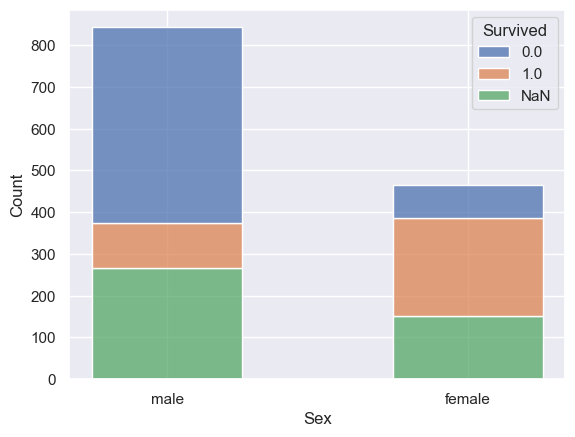

In [1572]:
sns.histplot(data=df, x='Sex', hue='Survived', multiple='stack', shrink=0.5)


As we can see, the per cent of survived women is much higher than men. This feature looks informative.


<h4> 1.2 Pclass </h4>


<AxesSubplot: xlabel='Pclass', ylabel='Count'>

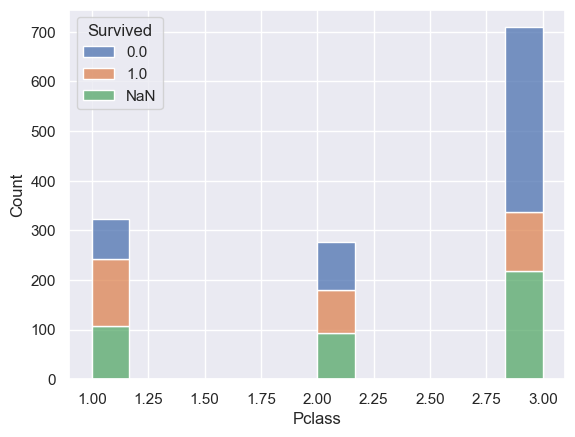

In [1573]:
sns.histplot(data=df, x='Pclass', hue='Survived', multiple='stack', shrink=1)


The number of survivors in the 3rd class is significantly low. Probably, it is connected with the location of these people in the moment of accident. I can assume that the lower class means the lower deck.

Overall, this feature is informative.


<h4> 1.3 Age </h4>


<AxesSubplot: xlabel='Age', ylabel='Count'>

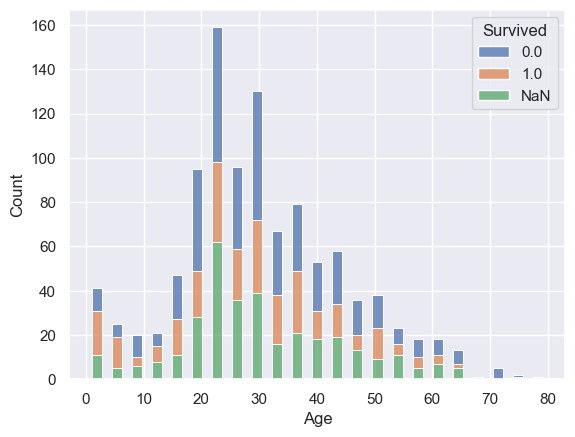

In [1574]:
sns.histplot(data=df,
             x='Age',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


We see that a lot of kids were saved. On the other hand, the old people have a high death rating.
Considering that a few people above 65, I'll change the age of these people to 65.


In [1575]:
df.loc[df['Age'] >= 65, 'Age'] = 65


<h4> 1.4 Siblings and spouse (SibSp)</h4>


<AxesSubplot: xlabel='SibSp', ylabel='Count'>

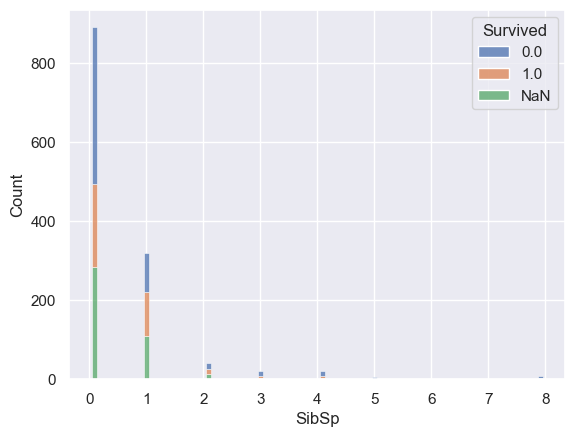

In [1576]:
sns.histplot(data=df,
             x='SibSp',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='SibSp', ylabel='Count'>

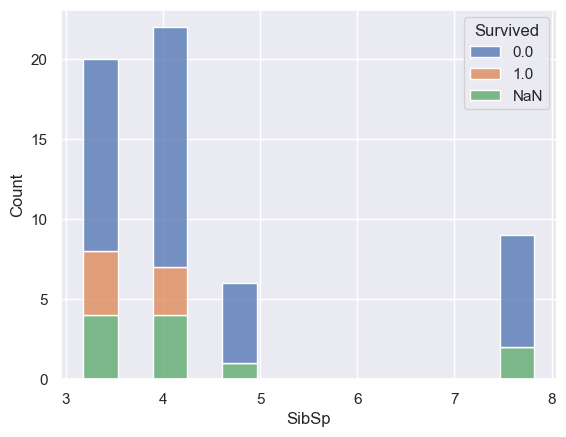

In [1577]:
# Closer look at big families
sns.histplot(data=df.loc[df['SibSp'] > 2],
             x='SibSp',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


Many people with several siblings did not survive... I'll combine all values in three categories:

<ul>
  <li>0: no siblings and no spouse</li>
  <li>1: 1-2 siblings or a spouse </li>
  <li>2: more than 2</li>
</ul>


In [1578]:
df.loc[(df['SibSp'] == 0), 'SibSp'] = 0
df.loc[(df['SibSp'] > 0) & (df['SibSp'] < 3), 'SibSp'] = 1
df.loc[df['SibSp'] >= 3, 'SibSp'] = 2


<h4> 1.5 Parents and children (Parch)</h4>


<AxesSubplot: xlabel='Parch', ylabel='Count'>

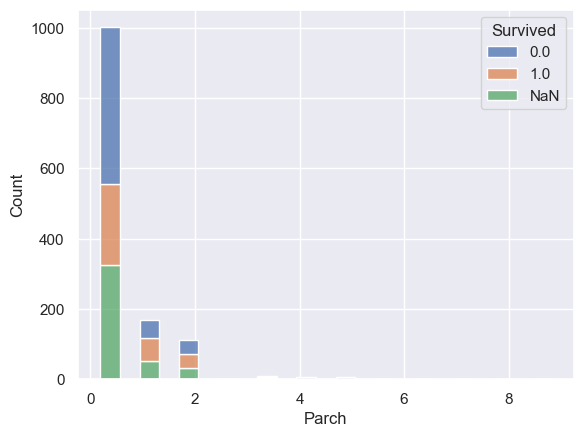

In [1579]:
sns.histplot(data=df,
             x='Parch',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='Parch', ylabel='Count'>

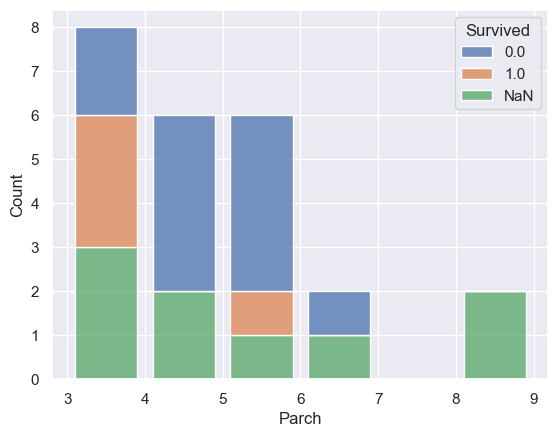

In [1580]:
# Closer look at big families
sns.histplot(data=df.loc[df['Parch'] > 2],
             x='Parch',
             hue='Survived',
             multiple='stack',
             shrink=0.8)


Same story for passengers with many children. So, the same tactic.

<ul>
  <li>0: no children or parents</li>
  <li>1: 1-3 parents and children </li>
  <li>2: more than 3</li>
</ul>


In [1581]:
df.loc[(df['Parch'] == 0), 'Parch'] = 0
df.loc[(df['Parch'] > 0) & (df['Parch'] <= 3), 'Parch'] = 1
df.loc[df['Parch'] >= 4, 'Parch'] = 2


<h4> 1.6 Embarked </h4>


<AxesSubplot: xlabel='Embarked', ylabel='Count'>

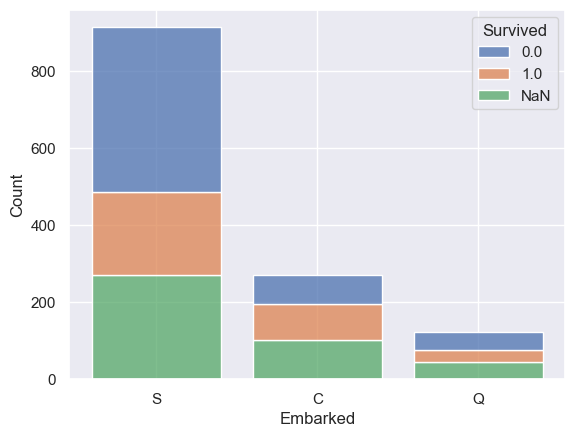

In [1582]:
sns.histplot(data=df,
             x='Embarked',
             hue='Survived',
             multiple='stack',
             shrink=0.8)


<h4> 1.7 Cabin </h4>


Let's keep from all cavin values just the first letter to show a sector of the ship. All empyt values I fill as N/A


In [1583]:
df['Cabin'] = df['Cabin'].fillna('N/A')
df['Section'] = df['Cabin'].apply(
    lambda x: str(x)[:1] if x != 'N/A' else 'N/A')


<AxesSubplot: xlabel='Section', ylabel='Count'>

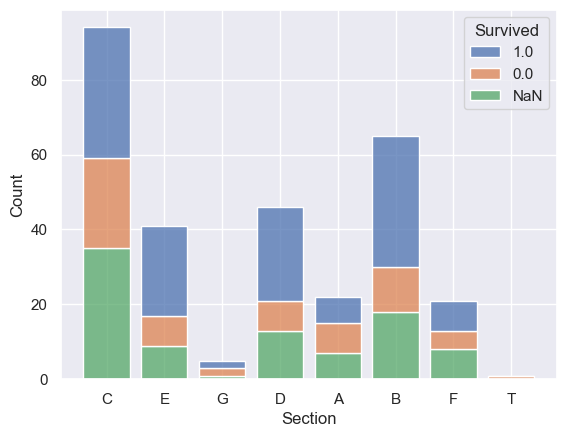

In [1584]:
sns.histplot(data=df.loc[(df['Section'] != 'N/A')],
             x='Section',
             hue='Survived',
             multiple='stack',
             shrink=0.8)


We can see that the number of survived people are significant in some sections. This feature seems informative even with many empty values. However, I'll fill a row with a single T section with N/A because it doesn't exist in the test set.


In [1585]:
df.loc[df['Section'] == 'T', 'Section'] = 'N/A'


<h4> 1.8 Names </h4>


In [1586]:
df[["Surname", "Name"]] = [i.split(",") for i in df["Name"].values]


In [1587]:
a = df.groupby("Surname")["Surname"].count()
fam_list = a[a > 1].index.values
df.loc[~df["Surname"].isin(fam_list), "Surname"] = "Other"


In [1588]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Surname"] != "Other"]
fig = px.histogram(dfplt, x="Surname", color="Survived",
                   color_discrete_sequence=cm)
fig.show()


Let's add a column with information about namesakes.


In [1589]:
df["Namesakes"] = 1
df.loc[df["Surname"] == "Other", "Namesakes"] = 0


I'm going to put the title of every person in the separate column and use it as as a kind of age category


In [1590]:
df["Title"] = pd.DataFrame(df["Name"].str.strip().str.split(
    ".").tolist()).set_index(df.index).iloc[:, 0]
df["Title"] = df["Title"].fillna("Others")


In [1591]:
fig = px.histogram(df, x="Title", color="Survived", color_discrete_sequence=cm)
fig.show()


In [1592]:
# The only female doctor
df.loc[df['Name'] == 'Dr. Alice (Farnham)', 'Title'] = 'Mrs'


Let's categorize rare titles to Miss, Mrs, and Mr. Master title is used for male children.


In [1593]:
rename = {"Miss": ["Ms", 'Mlle'],
          "Mrs": ["Mme", "Lady", "the Countess", "Dona"],
          "Mr": ['Capt', "Dr", "Sir", 'Col', 'Major', 'Don', 'Rev', 'Captain', "Jonkheer"]
          }
for k in rename:
    df["Title"] = df["Title"].replace(rename[k], k)


In [1594]:
fig = px.histogram(df, x="Title", color="Survived", color_discrete_sequence=cm)
fig.show()


<h4> 1.10 Ticket </h4>


I'm going to take a letter code from every possible ticket and put it in the separate column


In [1595]:
def lin_rep(x): return x.replace({'LINE': "370160"})


df = lin_rep(df)


In [1596]:
prefixes = []
nums, prefs = [], []
for i in df["Ticket"].values:
    if not i.isdigit():
        nums.append(int(re.search('.* {1}([0-9]+)', i).groups()[0]))
        prefix = re.search('(.*)( {1})[0-9]+', i).groups()[0]
        # Needed to put in one group such prefixes as "A/5", "A/5.", "A.5" etc.
        prefs.append(prefix.replace(".", "").replace(" ", "").replace("/", ""))
    else:
        nums.append(int(i))
        prefs.append("")
df["Ticket"] = nums
df["Ticket_p"] = prefs


In [1597]:
dfplt = df.copy(deep=True)
fig = px.scatter(dfplt.astype(str), x="Ticket_p", y="Name", color="Survived",
                 color_discrete_sequence=cm, size_max=6, width=1200, height=500)
fig.show()


In [1598]:
drop = ["SP", "SOP", "Fa", "SCOW", "PPP", "AS", "CASOTON", "SWPP",
        "SCAHBasle", "SCA3", "STONOQ", "AQ4", "A2", "LP", "AQ3", ""]
df = df.replace(drop, 'N/A')


<h1> 2. Preprocessing </h1>


In [1599]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   int64  
 9   Fare         1308 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1307 non-null   object 
 12  Section      1309 non-null   object 
 13  Surname      1309 non-null   object 
 14  Namesakes    1309 non-null   int64  
 15  Title        1309 non-null   object 
 16  Ticket_p     1309 non-null   object 
dtypes: float64(2), int64(6), object(9)
memory usage: 174.0+ KB


<h4> 2.1 Embarked </h4>


Due to a categorical type, I fill with the most frequent value


In [1600]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[['Embarked']] = imp_mean.fit_transform(df[['Embarked']])


<h4> 2.2 One Hot Encoder </h4>


In [1601]:
def use_ohe(df, features):
    df_local = pd.DataFrame()
    for feature in features:
        ohe = preprocessing.OneHotEncoder()
        transformed = ohe.fit_transform(df[[feature]])
        df_local[ohe.get_feature_names_out()] = transformed.toarray()
    return df_local


In [1602]:
df.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Section', 'Surname',
       'Namesakes', 'Title', 'Ticket_p'],
      dtype='object')

Obvious categorical values are Embarked, Title, Section, and Ticket_p.
Pclass, SibSp, and Parch are kept as a continuous variables because the higher or lower value causes the difference in surviving rate


In [1603]:
for_ohe = ['Embarked', 'Title', 'Section', 'Ticket_p']


df_final = pd.concat([df['Sex'].apply(lambda x: int(x == 'male')).copy(),
                      df[['Age', 'Pclass', 'SibSp', 'Parch', 'Namesakes']].copy(),
                      use_ohe(df, for_ohe)],
                     axis=1)


<h4> 2.3 Filling NaN values in the Age column </h4>


There are many empty values in the Age column, so I need to find a complex way to deal with them instead of just imputing mean or meadian of all values.
I'm going to predict them.


In [1604]:
age_features = np.delete(df_final.columns.to_numpy(), 1)

age_x_train = df_final[~df_final['Age'].isna()].drop('Age', axis=1)[
    age_features]
age_y_train = df_final[~df_final['Age'].isna()]['Age']
age_x_test = df_final[df_final['Age'].isna()].drop('Age', axis=1)[age_features]
age_y_test = df_final[df_final['Age'].isna()]['Age']

model = LinearRegression()
model.fit(age_x_train, age_y_train)

age_predict = model.predict(age_x_test)
df_final.loc[df_final['Age'].isnull(), 'Age'] = age_predict


In [1605]:
fig = px.histogram(df_final, x="Age",
                   color=df["Survived"], color_discrete_sequence=cm)
fig.show()


Look closer to kids and elder people


In [1606]:
kid_index = df_final[df_final['Age'] < 18].index
fig = px.histogram(df_final.loc[kid_index], x="Age",
                   color=df.loc[kid_index]["Survived"], color_discrete_sequence=cm)
fig.show()


In [1607]:
old_index = df_final[df_final['Age'] > 60].index
fig = px.histogram(df_final.loc[old_index], x="Age",
                   color=df.loc[old_index]["Survived"], color_discrete_sequence=cm)
fig.show()


In [1608]:
df_final['Kid'] = df_final['Age'].apply(lambda x: 1 if x < 8 else 0)
df_final['Old'] = df_final['Age'].apply(lambda x: 1 if x > 60 else 0)


<h1> 3. Neural Network </h1>


In [1609]:
df_final.columns


Index(['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Namesakes', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Kid', 'Old'],
      dtype='object')

I'm going to use a simple neural network in this time


In [1610]:
x = df_final.loc[train_index]

rng = 42

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=rng)


In [1611]:
def create_model(my_learning_rate, my_metrics, shape):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units=shape[1] * 2, input_shape=(shape[1], ),
                                    kernel_regularizer=tf.keras.regularizers.l2(
                                        l2=0.01),
                                    kernel_initializer='normal',
                                    activation='selu'),)

    model.add(tf.keras.layers.Dense(units=shape[1] * 4,
                                    kernel_regularizer=tf.keras.regularizers.l2(
                                        l2=0.01),
                                    kernel_initializer='normal',
                                    activation='selu'),)

    model.add(tf.keras.layers.Dense(units=1,
                                    activation=tf.sigmoid),)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=my_metrics)

    return model


def train_model(model, x, epochs, y,
                batch_size=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=x, y=y, batch_size=batch_size,
                        epochs=epochs, shuffle=shuffle,
                        validation_split=0.2)

    epochs = history.epoch

    hist = pd.DataFrame(history.history)

    return epochs, hist


print("Defined the create_model and train_model functions.")


Defined the create_model and train_model functions.


In [1612]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()


print("Defined the plot_curve function.")


Defined the plot_curve function.


In [1613]:
# The following variables are the hyperparameters.
learning_rate = 0.00005
epochs = 150
batch_size = 3
classification_threshold = 0.6

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                    threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold,
                               name='precision'
                               ),
    tf.keras.metrics.Recall(thresholds=classification_threshold,
                            name="recall"),
]

# Establish the model's topography.
model = create_model(learning_rate, METRICS, x_train.shape)
model.summary()


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 30)                480       
                                                                 
 dense_137 (Dense)           (None, 60)                1860      
                                                                 
 dense_138 (Dense)           (None, 1)                 61        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


Epoch 1/150


c:\Users\Василий\.pyenv\pyenv-win\versions\3.10.8\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



166/166 [==============================] - 1s 4ms/step - loss: 0.7492 - accuracy: 0.5924 - precision: 0.3871 - recall: 0.1270 - val_loss: 0.6839 - val_accuracy: 0.6640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
166/166 [==============================] - 0s 2ms/step - loss: 0.7041 - accuracy: 0.6205 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6785 - val_accuracy: 0.6640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/150
166/166 [==============================] - 1s 3ms/step - loss: 0.6973 - accuracy: 0.6205 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6670 - val_accuracy: 0.6640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/150
166/166 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.6205 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6572 - val_accuracy: 0.6640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/150
166/166 [==============================] - 0

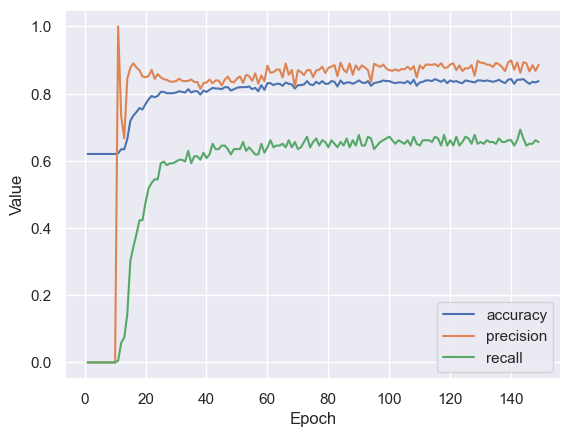

In [1614]:
# Train the model on the training set.
epochs, hist = train_model(model, x_train, epochs,
                           y_train, batch_size)

# # Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']

plot_curve(epochs, hist, list_of_metrics_to_plot)


In [1615]:
model.evaluate(x=x_test, y=y_test, batch_size=batch_size)


90/90 [==============================] - 0s 1ms/step - loss: 0.4492 - accuracy: 0.7948 - precision: 0.8415 - recall: 0.6216


[0.4491863250732422,
 0.7947761416435242,
 0.8414633870124817,
 0.6216216087341309]

In [1616]:
pred = model.predict(x=df_final.loc[test_index], batch_size=batch_size)
res = [0 if el[0] < classification_threshold else 1 for el in pred]
# print(res)
pd.DataFrame({
    'PassengerId': df.loc[test_index]['PassengerId'],
    'Survived': res
}).to_csv('submission.csv', index=False)


140/140 [==============================] - 0s 1ms/step
